In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GRU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df_frames = pd.read_csv('../data/fox-falco-fd-frames.csv')

In [3]:
df_frames.drop(columns = ['Unnamed: 0', 'fox_last_hit_by', 'nfox_last_hit_by'], inplace = True)

In [4]:
df_frames

,game_id,frame_index,fox_cstick_x,fox_cstick_y,fox_joystick_x,fox_joystick_y,fox_Y,fox_X,fox_B,fox_A,...,nfox_Z,nfox_combo_count,nfox_dmg,nfox_direction,nfox_position_x,nfox_position_y,nfox_shield,nfox_state,nfox_state_age,nfox_stocks
0,20190406T144505,-123,0.0,0.0,0.0,0.0,0,0,0,0,...,0,0,0.000000,1,-60.000000,10.0000,60.0,322,-1.000000,4
1,20190406T144505,-122,0.0,0.0,0.0,0.0,0,0,0,0,...,0,0,0.000000,1,-60.000000,10.0000,60.0,322,-1.000000,4
2,20190406T144505,-121,0.0,0.0,0.0,0.0,0,0,0,0,...,0,0,0.000000,1,-60.000000,10.0000,60.0,322,-1.000000,4
3,20190406T144505,-120,0.0,0.0,0.0,0.0,0,0,0,0,...,0,0,0.000000,1,-60.000000,10.0000,60.0,322,-1.000000,4
4,20190406T144505,-119,0.0,0.0,0.0,0.0,0,0,0,0,...,0,0,0.000000,1,-60.000000,10.0000,60.0,322,-1.000000,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106173,20190406T114529,9339,0.0,0.0,0.0,0.0,0,0,0,0,...,0,1,101.099998,1,-65.303207,0.0001,60.0,21,1.868056,2
106174,20190406T114529,9340,0.0,0.0,0.0,0.0,0,0,0,0,...,0,1,101.099998,1,-63.821957,0.0001,60.0,21,2.725260,2
106175,20190406T114529,9341,0.0,0.0,0.0,0.0,0,0,0,0,...,0,1,101.099998,1,-62.340706,0.0001,60.0,21,3.582465,2
106176,20190406T114529,9342,0.0,0.0,0.0,0.0,0,0,0,0,...,0,1,101.099998,1,-60.859455,0.0001,60.0,21,4.439670,2


In [5]:
set(df_frames['game_id'].values)

{'20190309T012347',
 '20190406T102328',
 '20190406T104203',
 '20190406T105900',
 '20190406T114015',
 '20190406T114529',
 '20190406T143503',
 '20190406T144505',
 '20190406T175827',
 '20190406T183745',
 '20190406T190322',
 '20190406T190420',
 '20190406T214523'}

In [6]:
missed_tech = [183, 188, 189, 191, 196, 197]
df_frames['fox_state'] = df_frames['fox_state'].apply(lambda val: val if val not in missed_tech else 999)

In [7]:
missed_and_techs = [999, 199, 200, 201]
df_frames['target'] = df_frames['fox_state'].apply(lambda val: 0 if val not in missed_and_techs else (1 if val == 999 else (2 if val == 199 else (3 if val == 200 else 4))))

In [8]:
# class imbalance
df_frames['target'].value_counts(normalize = True)

0    0.966650
1    0.020711
2    0.005444
4    0.004379
3    0.002816
Name: target, dtype: float64

In [9]:
df_frames.columns

Index(['game_id', 'frame_index', 'fox_cstick_x', 'fox_cstick_y',
       'fox_joystick_x', 'fox_joystick_y', 'fox_Y', 'fox_X', 'fox_B', 'fox_A',
       'fox_L', 'fox_R', 'fox_Z', 'fox_combo_count', 'fox_dmg',
       'fox_direction', 'fox_position_x', 'fox_position_y', 'fox_shield',
       'fox_state', 'fox_state_age', 'fox_stocks', 'nfox_cstick_x',
       'nfox_cstick_y', 'nfox_joystick_x', 'nfox_joystick_y', 'nfox_Y',
       'nfox_X', 'nfox_B', 'nfox_A', 'nfox_L', 'nfox_R', 'nfox_Z',
       'nfox_combo_count', 'nfox_dmg', 'nfox_direction', 'nfox_position_x',
       'nfox_position_y', 'nfox_shield', 'nfox_state', 'nfox_state_age',
       'nfox_stocks', 'target'],
      dtype='object')

In [10]:
df_frames = pd.get_dummies(df_frames, columns = ['fox_state', 'nfox_state', 'fox_direction', 'nfox_direction'])

In [11]:
# Expecting 578 rows
df_frames.loc[df_frames['fox_state_199'] == 1]

,game_id,frame_index,fox_cstick_x,fox_cstick_y,fox_joystick_x,fox_joystick_y,fox_Y,fox_X,fox_B,fox_A,...,nfox_state_440,nfox_state_441,nfox_state_442,nfox_state_443,nfox_state_445,nfox_state_446,fox_direction_-1,fox_direction_1,nfox_direction_-1,nfox_direction_1
12847,20190406T190420,4275,0.0,0.0,0.0000,0.9875,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
12848,20190406T190420,4276,0.0,0.0,0.0000,0.9875,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
12849,20190406T190420,4277,0.0,0.0,0.0000,0.9875,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
12850,20190406T190420,4278,0.0,0.0,0.0000,0.9875,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
12851,20190406T190420,4279,0.0,0.0,0.0000,0.9875,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105298,20190406T114529,8464,0.0,0.0,0.9375,0.3250,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
105299,20190406T114529,8465,0.0,0.0,0.9375,0.3250,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
105300,20190406T114529,8466,0.0,0.0,0.9375,0.3250,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
105301,20190406T114529,8467,0.0,0.0,0.9375,0.3250,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0


In [12]:
# Expecting 299 rows
df_frames.loc[df_frames['fox_state_200'] == 1]

,game_id,frame_index,fox_cstick_x,fox_cstick_y,fox_joystick_x,fox_joystick_y,fox_Y,fox_X,fox_B,fox_A,...,nfox_state_440,nfox_state_441,nfox_state_442,nfox_state_443,nfox_state_445,nfox_state_446,fox_direction_-1,fox_direction_1,nfox_direction_-1,nfox_direction_1
9826,20190406T190420,1254,0.0,0.0,-0.9500,-0.2875,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
9827,20190406T190420,1255,0.0,0.0,-0.9625,0.0000,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
9828,20190406T190420,1256,0.0,0.0,-0.9750,0.0000,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
9829,20190406T190420,1257,0.0,0.0,-0.9875,0.0000,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
9830,20190406T190420,1258,0.0,0.0,-0.9875,0.0000,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103325,20190406T114529,6491,0.0,0.0,0.0000,-0.9875,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
103326,20190406T114529,6492,0.0,0.0,0.0000,-0.9875,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
103327,20190406T114529,6493,0.0,0.0,0.0000,-0.9875,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
103328,20190406T114529,6494,0.0,0.0,0.0000,-0.9875,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1


In [13]:
# Expecting 465 rows
df_frames.loc[df_frames['fox_state_201'] == 1]

,game_id,frame_index,fox_cstick_x,fox_cstick_y,fox_joystick_x,fox_joystick_y,fox_Y,fox_X,fox_B,fox_A,...,nfox_state_440,nfox_state_441,nfox_state_442,nfox_state_443,nfox_state_445,nfox_state_446,fox_direction_-1,fox_direction_1,nfox_direction_-1,nfox_direction_1
4124,20190406T144505,4001,0.0,0.0,0.9875,0.0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
4125,20190406T144505,4002,0.0,0.0,0.9875,0.0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
4126,20190406T144505,4003,0.0,0.0,0.9875,0.0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
4127,20190406T144505,4004,0.0,0.0,0.9875,0.0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
4128,20190406T144505,4005,0.0,0.0,0.9875,0.0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95156,20190406T143503,5470,0.0,0.0,0.0000,0.0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
95157,20190406T143503,5471,0.0,0.0,0.0000,0.0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
95158,20190406T143503,5472,0.0,0.0,0.0000,0.0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
95159,20190406T143503,5473,0.0,0.0,0.0000,0.0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0


In [14]:
set(df_frames['game_id'])

{'20190309T012347',
 '20190406T102328',
 '20190406T104203',
 '20190406T105900',
 '20190406T114015',
 '20190406T114529',
 '20190406T143503',
 '20190406T144505',
 '20190406T175827',
 '20190406T183745',
 '20190406T190322',
 '20190406T190420',
 '20190406T214523'}

In [15]:
df_frames = df_frames.loc[(df_frames['game_id'] == '20190309T012347') | (df_frames['game_id'] == '20190406T102328') | \
             (df_frames['game_id'] == '20190406T104203')]

In [16]:
X = df_frames.drop(columns = ['game_id', 'frame_index', 'target'])
y = to_categorical(df_frames['target'])

In [17]:
# Since I cannot set random_state to 20XX, I will set it to 2099
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle = False, random_state = 2099)

In [18]:
ss = StandardScaler()
Z_train = ss.fit_transform(X_train)
Z_test = ss.transform(X_test)

In [19]:
train_sequences = TimeseriesGenerator(Z_train, y_train,
                                     length = 120, batch_size = 512)

In [20]:
train_sequences[0][0].shape

(512, 120, 337)

In [21]:
test_sequences = TimeseriesGenerator(Z_test, y_test,
                                    length = 120, batch_size = 512)

In [22]:
Z_train.shape

(16370, 337)

In [23]:
model = Sequential()

model.add(GRU(337, input_shape = (120, 337), return_sequences = True))
model.add(GRU(337, return_sequences = False))

model.add(Dense(128, activation = 'relu'))

model.add(Dense(5, activation = 'softmax'))

# early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')
model.compile(loss = 'categorical_crossentropy', optimizer = Adam(0.001), metrics = ['accuracy'])

In [24]:
hist = model.fit_generator(train_sequences, epochs = 5, validation_data = test_sequences)

Epoch 1/5
32/32 [==============================] - 587s 18s/step - loss: 0.6368 - accuracy: 0.7937 - val_loss: 0.1478 - val_accuracy: 0.9696
Epoch 2/5
32/32 [==============================] - 548s 17s/step - loss: 0.0335 - accuracy: 0.9911 - val_loss: 0.1056 - val_accuracy: 0.9835
Epoch 3/5
32/32 [==============================] - 542s 17s/step - loss: 0.0185 - accuracy: 0.9955 - val_loss: 0.0917 - val_accuracy: 0.9828
Epoch 4/5
32/32 [==============================] - 7042s 220s/step - loss: 0.0090 - accuracy: 0.9978 - val_loss: 0.0985 - val_accuracy: 0.9828
Epoch 5/5
32/32 [==============================] - 551s 17s/step - loss: 0.0061 - accuracy: 0.9982 - val_loss: 0.0972 - val_accuracy: 0.9829


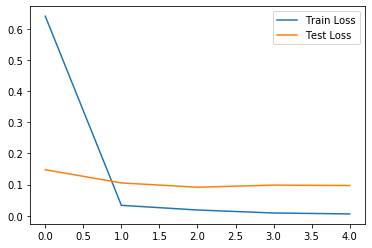

In [25]:
plt.plot(hist.history['loss'], label = 'Train Loss')
plt.plot(hist.history['val_loss'], label = 'Test Loss')
plt.legend()